# Julia Webexperiment Extract Individual Responses

In [13]:
import pandas as pd

# Read data
df = pd.read_csv('dortmund-data-r.csv', sep=';')
# Remove unneccesary columns
df = df[['id', 'subject_group', 'token', 'answer_values', 'element_id',
         'hidden_figure', 'hidden_inference', 'hidden_maximum', 'hidden_minimum']]
df = df.drop(['subject_group', 'hidden_maximum', 'hidden_minimum'], axis=1)

# Extract all conditional tasks (start with 'agree')
# This still contains numerical/interval agreement values
df['task'] = df['element_id'].apply(lambda x: True if x.startswith('agree') else False)
task_df = df.loc[df['task']].copy()

# Extract all yes-no-unknown tasks
# This filters out numerical agreement values
def infer_categorical(x):
    if x in ['yes', 'no', 'unknown']:
        return True
    return False

task_df['categorical'] = task_df['answer_values'].apply(infer_categorical)
categorical_df = task_df.loc[task_df['categorical']].drop('categorical', axis=1)

# Binarize answers
def categorical_correctness(x):
    if x.lower() == 'yes':
        return 1
    return 0
categorical_df['correctness'] = categorical_df['answer_values'].apply(categorical_correctness)
binary_df = categorical_df.drop(['id', 'answer_values', 'task', 'element_id'], axis=1)

# Drop participants with missing values

# How many questions did participants answer?
correct_number_responses = binary_df['token'].value_counts()
# Paste this into the original data frame
individuals = binary_df.join(correct_number_responses, on='token', how='left', rsuffix='_number')
# Drop participants who did not answer all 36 questions
individuals = individuals[individuals.token_number == 36]

# Transform long format to individual format

# Sum over all binary acceptances
individuals = individuals.groupby(['token', 'hidden_inference', 'hidden_figure'], as_index=False)['correctness'].agg('sum')

# Consider only Deduction
deductions = individuals[individuals.hidden_inference == 'Deduction']
deductions = deductions.pivot(index='token', columns='hidden_figure', values='correctness')
deductions.columns.name, deductions.index.name = 'Deduction', 'token'
deductions = deductions[['MP', 'MT', 'AC', 'DA']]

deductions.to_csv('deduction_individual_responses.csv', sep=',', index=True, header=True)
display(deductions.iloc[0:5])

# Consider only Abduction
abductions = individuals[individuals.hidden_inference == 'Abduction']
abductions = abductions.pivot(index='token', columns='hidden_figure', values='correctness')
abductions.columns.name, abductions.index.name = 'Abduction', 'token'
abductions = abductions[['MP', 'MT', 'AC', 'DA']]

abductions.to_csv('abduction_individual_responses.csv', sep=',', index=True, header=True)
display(abductions.iloc[0:5])

Deduction,MP,MT,AC,DA
token,,,,
0I2kyX7,3,3,1,3
0iEtfX6,3,3,3,3
1WZxpN9,3,2,2,2
3UlceN0,3,2,3,1
3euCGN5,3,0,3,1


Abduction,MP,MT,AC,DA
token,,,,
0I2kyX7,3,3,3,3
0iEtfX6,3,3,3,2
1WZxpN9,2,2,3,2
3UlceN0,3,0,3,2
3euCGN5,2,0,3,0


In [36]:
# Check: read data in again
test_abduction = pd.read_csv('abduction_individual_responses.csv', sep=',')
test_deduction = pd.read_csv('deduction_individual_responses.csv', sep=',')

display(test_abduction.iloc[0:5])

# Compare to old data
display((test_abduction.set_index('token') == abductions).all())
display((test_deduction.set_index('token') == deductions).all())

,token,AC,DA,MP,MT
0,0I2kyX7,3,3,3,3
1,0iEtfX6,3,2,3,3
2,1WZxpN9,3,2,2,2
3,3UlceN0,3,2,3,0
4,3euCGN5,3,0,2,0


AC    True
DA    True
MP    True
MT    True
dtype: bool

AC    True
DA    True
MP    True
MT    True
dtype: bool

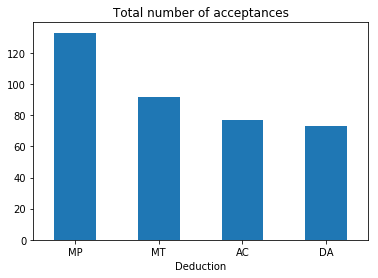

In [46]:
import matplotlib.pyplot as plt
deductions.sum(axis=0).plot(kind='bar', rot=0, title='Total number of acceptances')
plt.show()

In [14]:
display(len(deductions))
display(len(abductions))

49

49